In [0]:
### 前準備
import pandas as pd
import io
import requests
import xgboost as xgb
import numpy as np
from sklearn import preprocessing
from google.colab import files

In [0]:
### 学習データの読み込みと確認
url="https://raw.githubusercontent.com/kuiski/kaggle_titanic/master/input/train.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
feature_data = c.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
feature_data[:20]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
7,3,male,2.0,3,1,21.0750,S
8,3,female,27.0,0,2,11.1333,S
9,2,female,14.0,1,0,30.0708,C


In [4]:
label_data = c.loc[:, ['Survived']]
label_data[:3]

,Survived
0,0
1,1
2,1


In [0]:
sex_encorder = preprocessing.LabelEncoder()
sex_encorder.fit(c['Sex'].astype(str))
feature_data['Sex'] = sex_encorder.transform(feature_data['Sex'])

In [0]:
embarked_encorder = preprocessing.LabelEncoder()
embarked_encorder.fit(c['Embarked'].astype(str))
feature_data['Embarked'] = embarked_encorder.transform(feature_data['Embarked'].astype(str))

In [7]:
feature_data.loc[:3]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2


In [8]:
data_X = np.array(feature_data)
data_Y = np.array(label_data)

print(data_X.shape)
print(data_Y.shape)

(891, 7)
(891, 1)


In [9]:
# TEST_DATAの読み込み
url="https://raw.githubusercontent.com/kuiski/kaggle_titanic/master/input/test.csv"
s=requests.get(url).content
test=pd.read_csv(io.StringIO(s.decode('utf-8')))

test_data = test.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
test_data['Embarked'] = embarked_encorder.transform(test_data['Embarked'].astype(str))
test_data['Sex'] = sex_encorder.transform(test_data['Sex'])

test_X = np.array(test_data)
print(test_X.shape)


(418, 7)


In [0]:

# 欠損値をゼロで置換
data_X[np.isnan(data_X)] = 200
data_Y[np.isnan(data_Y)] = 200
test_X[np.isnan(test_X)] = 200

In [11]:
### 無敵のディープラーニングでなんとかしてくださいよぉーーー！！
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt

# 深層学習モデルを保存するファイル名
saver_filename = './model.chkp'

# TESTとVALIDに分割
rng = np.random.RandomState(44)
train_X, valid_X, train_Y, valid_Y = train_test_split(data_X, data_Y, test_size=0.1, random_state=42)


print(train_X.shape)
print(valid_Y.shape)



(801, 7)
(90, 1)


In [0]:

# NeuralNetworkのLayerを定義
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(tf.zeros([out_dim], dtype=tf.float32), name='b')
        self.function = function
    def f_prop(self, x):
        return self.function(tf.einsum('ik,kl->il', x, self.W) + self.b)  
      

def design_model(feature_size, prediction_dim):
    x = tf.placeholder(tf.float32, [None, feature_size], name='x')
    t = tf.placeholder(tf.float32, [None, prediction_dim], name='t')

    # NeuralNetworkのモデル構造を定義
    layers = [
        Dense(feature_size, 40, tf.nn.relu),
        Dense(40, 30, tf.nn.relu),
        Dense(30, prediction_dim, tf.nn.sigmoid)
    ]
 
    def f_props(layers, x):
        for layer in layers:
            x = layer.f_prop(x)
        return x
    
    y = f_props(layers, x)
    cost = tf.reduce_mean(tf.square(y - t))
   
    return x,t,y,cost

In [0]:
# LOSS遷移を可視化
def CreateLossGraph(train_cost_list, test_cost_list):
    iter_list = range(1, len(train_cost_list)+1, 1)
    plt.figure()
    p_train = plt.plot(iter_list,train_cost_list)
    p_test  = plt.plot(iter_list,test_cost_list, linestyle="dashed") 
    plt.ylim([0,1])
    plt.legend((p_train[0], p_test[0]), ("TRAIN", "VALID"), loc=2)
    plt.grid(True)
    plt.show()

# 学習の実行
def estimate_model(train_X, train_Y, valid_X, valid_Y, test_X):  
    feature_size = train_X.shape[-1]
    prediction_dim = train_Y.shape[-1]
    x,t,y,cost = design_model(feature_size, prediction_dim)
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    
    saver_all = tf.train.Saver()    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # VALIDへのLOSS
    def score():
        if valid_X is None:
            return -1
        n_batches_valid = -(-len(valid_X) // batch_size)
        valid_costs = []
        for i in range(n_batches_valid):
            start = i * batch_size
            end = start + batch_size if (start + batch_size) < len(valid_X) else len(valid_X)
            valid_cost = sess.run(cost, feed_dict={x: valid_X[start:end], t: valid_Y[start:end]})
            valid_costs.append(valid_cost)
        return np.mean(valid_costs)

    # TRAINのLOSS
    n_batches = len(train_X) // batch_size
    valid_cost_min = np.inf
    train_cost_list, valid_cost_list = [], []
    for epoch in range(n_epochs):
        _train_X, _train_Y = shuffle(train_X, train_Y)
        train_costs = []
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size if (start + batch_size) < len(_train_X) else len(_train_X)
            _, train_cost = sess.run([train, cost], feed_dict={x: _train_X[start:end], t: _train_Y[start:end]})
            train_costs.append(train_cost)

        valid_cost = score()
        print('{:03d}, {:.5f}, {:.5f} (min:{:.5f})'.format(epoch+1, np.mean(train_costs), valid_cost, valid_cost_min))
        train_cost_list.append(np.mean(train_costs))
        valid_cost_list.append(valid_cost)

        # VALIDでLOSS最小のモデルを保存する
        if valid_cost < valid_cost_min:
            valid_cost_min = valid_cost
            epoch_min = epoch
            saver_all.save(sess,saver_filename)

    saver_all.restore(sess,saver_filename)
    predBest_train_Y  = sess.run(y, feed_dict={x: train_X})
    predBest_valid_Y  = sess.run(y, feed_dict={x: valid_X})
    predBest_test_Y   = sess.run(y, feed_dict={x: test_X})
    sess.close()
    
    # LOSSグラフ出力
    CreateLossGraph(train_cost_list, valid_cost_list)

    return predBest_train_Y, predBest_valid_Y, predBest_test_Y # BESTな予測値を返す



001, 0.31230, 0.20347 (min:inf)
002, 0.22144, 0.21345 (min:0.20347)
003, 0.21598, 0.21571 (min:0.20347)
004, 0.20580, 0.20493 (min:0.20347)
005, 0.19972, 0.18740 (min:0.20347)
006, 0.20051, 0.18222 (min:0.18740)
007, 0.19340, 0.17634 (min:0.18222)
008, 0.18598, 0.18192 (min:0.17634)
009, 0.18480, 0.20230 (min:0.17634)
010, 0.18896, 0.18957 (min:0.17634)
011, 0.18192, 0.16789 (min:0.17634)
012, 0.17445, 0.17007 (min:0.16789)
013, 0.18150, 0.15916 (min:0.16789)
014, 0.17655, 0.15874 (min:0.15916)
015, 0.18361, 0.16424 (min:0.15874)
016, 0.17203, 0.15851 (min:0.15874)
017, 0.17259, 0.15805 (min:0.15851)
018, 0.16600, 0.15623 (min:0.15805)
019, 0.16454, 0.15846 (min:0.15623)
020, 0.16753, 0.15578 (min:0.15623)
021, 0.15578, 0.15855 (min:0.15578)
022, 0.16823, 0.14549 (min:0.15578)
023, 0.15696, 0.14385 (min:0.14549)
024, 0.15563, 0.15286 (min:0.14385)
025, 0.14853, 0.14314 (min:0.14385)
026, 0.14964, 0.14168 (min:0.14314)
027, 0.15129, 0.14233 (min:0.14168)
028, 0.15861, 0.14669 (min:0.141

235, 0.13108, 0.15204 (min:0.13000)
236, 0.13712, 0.16401 (min:0.13000)
237, 0.12703, 0.14708 (min:0.13000)
238, 0.12071, 0.16464 (min:0.13000)
239, 0.12119, 0.15493 (min:0.13000)
240, 0.11984, 0.14743 (min:0.13000)
241, 0.12333, 0.15693 (min:0.13000)
242, 0.11788, 0.14701 (min:0.13000)
243, 0.11920, 0.14196 (min:0.13000)
244, 0.11940, 0.14617 (min:0.13000)
245, 0.12017, 0.15255 (min:0.13000)
246, 0.13040, 0.16065 (min:0.13000)
247, 0.12228, 0.14436 (min:0.13000)
248, 0.12236, 0.14786 (min:0.13000)
249, 0.11927, 0.16203 (min:0.13000)
250, 0.11798, 0.15912 (min:0.13000)
251, 0.12012, 0.14498 (min:0.13000)
252, 0.11788, 0.15134 (min:0.13000)
253, 0.12238, 0.14339 (min:0.13000)
254, 0.11873, 0.15957 (min:0.13000)
255, 0.11795, 0.14661 (min:0.13000)
256, 0.11399, 0.16223 (min:0.13000)
257, 0.11499, 0.17278 (min:0.13000)
258, 0.13308, 0.15827 (min:0.13000)
259, 0.11901, 0.16242 (min:0.13000)
260, 0.12321, 0.13781 (min:0.13000)
261, 0.11959, 0.14493 (min:0.13000)
262, 0.11753, 0.15158 (min:0

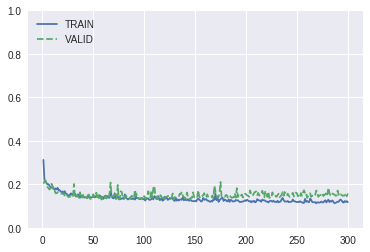

In [14]:
# ハイパーパラメータの設定
batch_size = 32
n_epochs = 300

predBest_train_Y, predBest_valid_Y, predBest_test_Y = estimate_model(train_X, train_Y, valid_X, valid_Y, test_X)

In [15]:

def probability2class(prediction_y):
  y_class=[]
  for y in prediction_y:
    if(y[0] < 0.5):
      y_class.append(0)
    else:
      y_class.append(1)
  return y_class


def calcAccuracy(truth, prediction):
    count = 0
    for i in range(len(truth)):
        if(truth[i][0] == prediction[i]):
          count+=1 
    print('{:d} / {:d}'.format(count, len(prediction)))
    print('Accuracy = {:.5f}'.format(count/len(prediction)))
    
print('TRAIN')
train_class_y = probability2class(predBest_train_Y)
calcAccuracy(train_Y, train_class_y) 
  
print('VALID')
valid_class_y = probability2class(predBest_valid_Y)
calcAccuracy(valid_Y, valid_class_y)

TRAIN
663 / 801
Accuracy = 0.82772
VALID
74 / 90
Accuracy = 0.82222


In [0]:

predictions = pd.DataFrame(probability2class(predBest_test_Y))
filename = "output.csv"

outputs = test.loc[:, ['PassengerId']]
outputs['Survived'] = predictions

outputs.to_csv(filename, index=False)
#outputs.to_csv(filename, header=False, index=False)
files.download(filename)